In [1]:
from datasets import load_dataset, load_from_disk

/root/anaconda3/envs/diff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_from_disk("/mnt/cephfs/sumin/sentence_kd/difficulty/math500_with_difficulty")

In [3]:
ds

Dataset({
    features: ['problem', 'solution', 'answer', 'subject', 'level', 'unique_id', 'difficulty'],
    num_rows: 500
})

In [ ]:
import re
from datasets import load_dataset, Dataset, DatasetDict

# Function to process a single example
def process_example(example):
    # Extract the difficulty
    difficulty = example.get('difficulty', 5)  # Default to 5 if not found
    
    # Process the text field to add difficulty information
    text = example['text']
    
    # Add difficulty instruction to the system message
    system_prompt_pattern = r'<\|im_start\|>system\nYou are Qwen, created by Alibaba Cloud\. You are a helpful assistant\.'
    system_prompt_replacement = f'<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant. Rate the difficulty of this problem on a scale of 1-10 and include it at the before of your thinking. Example: Difficulty: 5/10'
    
    text = re.sub(system_prompt_pattern, system_prompt_replacement, text)
    
    # Add difficulty at the beginning of the assistant's response
    assistant_pattern = r'<\|im_start\|>assistant\n<\|im_start\|>think'
    assistant_replacement = f'<|im_start|>assistant\nDifficulty: {difficulty}/10\n<|im_start|>think'
    
    # Replace only the first occurrence (the start of the assistant's response)
    text = re.sub(assistant_pattern, assistant_replacement, text)
    print(text)
    # Update the text field in the example
    example['text'] = text
    
    return example

# Load your dataset (replace with your actual dataset path/name)
original_dataset = load_from_disk("/mnt/cephfs/sumin/sentence_kd/dataset/raw/s1k_math_with_difficulty")

# Check if we got a Dataset or DatasetDict
if hasattr(original_dataset, 'keys'):
    # It's a DatasetDict
    available_splits = list(original_dataset.keys())
    print(f"Available splits in the original dataset: {available_splits}")
    
    # Use the first available split
    if 'train' in available_splits:
        main_data = original_dataset['train']
    else:
        main_data = original_dataset[available_splits[0]]
else:
    # It's a Dataset (no splits)
    print("Original dataset has no splits, using it directly")
    main_data = original_dataset

# Apply the processing function to each example
processed_data = main_data.map(process_example)

# Ensure 'difficulty' is in the features
if 'difficulty' not in processed_data.column_names:
    # Create a default difficulty if it doesn't exist
    processed_data = processed_data.add_column('difficulty', [5] * len(processed_data))

# Create a new DatasetDict with train split
processed_dataset = DatasetDict({
    'train': processed_data
})

# Print information about the processed dataset
print("\nProcessed dataset structure:")
print(f"DatasetDict({{")
print(f"    train: Dataset({{")
print(f"        features: {processed_dataset['train'].column_names},")
print(f"        num_rows: {len(processed_dataset['train'])}")
print(f"    }}")
print(f"}})")

# Save the processed dataset
processed_dataset.save_to_disk("processed_dataset")

print("\nDataset successfully saved to 'processed_dataset'")

# If you want to verify the changes in a specific example:
print("\nExample before and after processing:")
print("Original:")
print(main_data[0]["text"][:300] + "...")  # Show first 300 chars
print("\nProcessed:")
print(processed_dataset["train"][0]["text"][:300] + "...")  # Show first 300 chars

In [10]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. 데이터셋 로드
dataset = load_from_disk("/mnt/cephfs/sumin/sentence_kd/difficulty/math500_with_difficulty")  # 실제 경로로 변경해주세요
# train_dataset = dataset['train']
train_dataset = dataset

# 2. 데이터를 DataFrame으로 변환
df = pd.DataFrame(train_dataset)

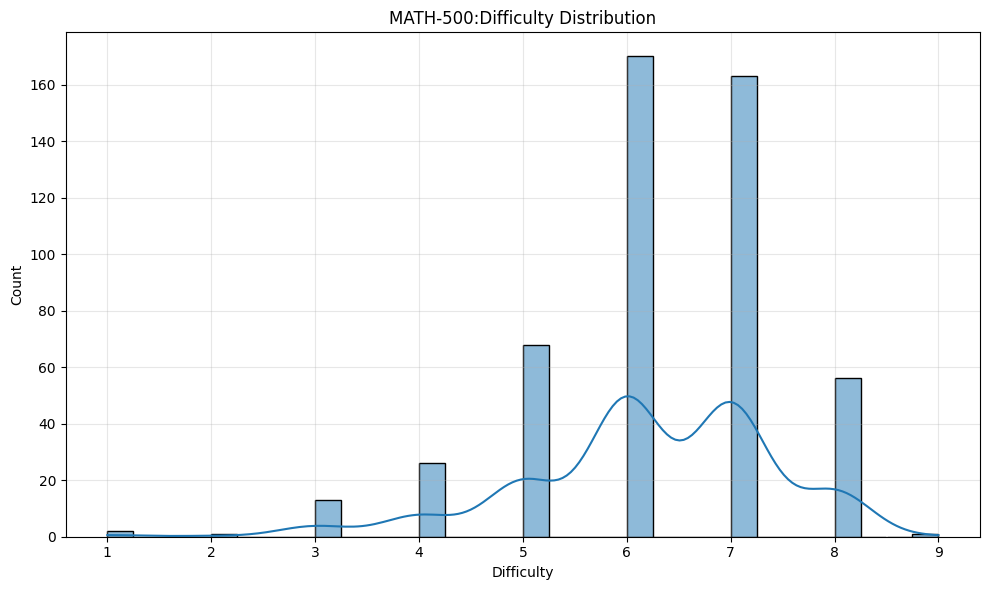

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='difficulty', kde=True)
plt.title('MATH-500:Difficulty Distribution')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('difficulty_histogram.png')
plt.show()

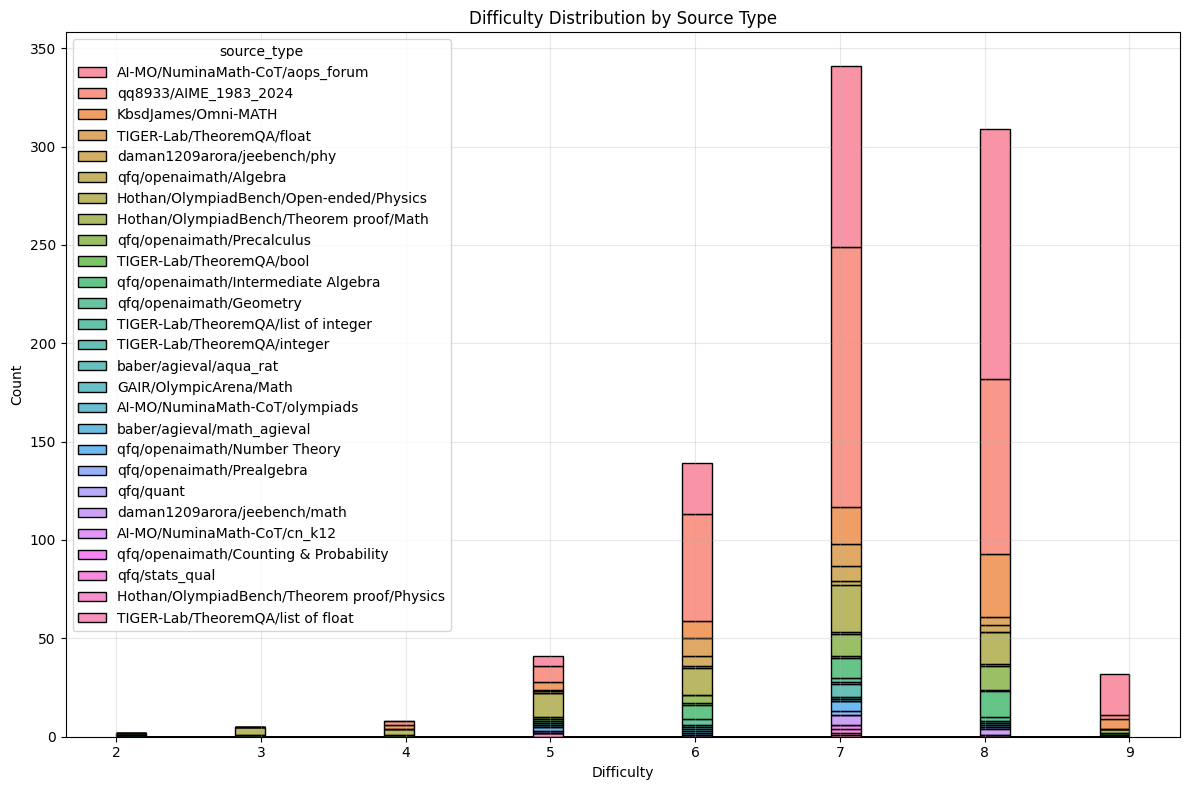

In [8]:
plt.figure(figsize=(12, 8))
# legend 표시 문제 해결을 위해 ax 객체를 명시적으로 생성
ax = sns.histplot(data=df, x='difficulty', hue='source_type', multiple='stack', kde=False)
plt.title('Difficulty Distribution by Source Type')
plt.xlabel('Difficulty')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
# 범례가 제대로 표시되도록 함
handles, labels = ax.get_legend_handles_labels()
if len(handles) > 0:  # 핸들이 있는 경우에만 범례 추가
    ax.legend(title='Source Type')
plt.tight_layout()
plt.savefig('difficulty_by_source_histogram.png')
plt.show()

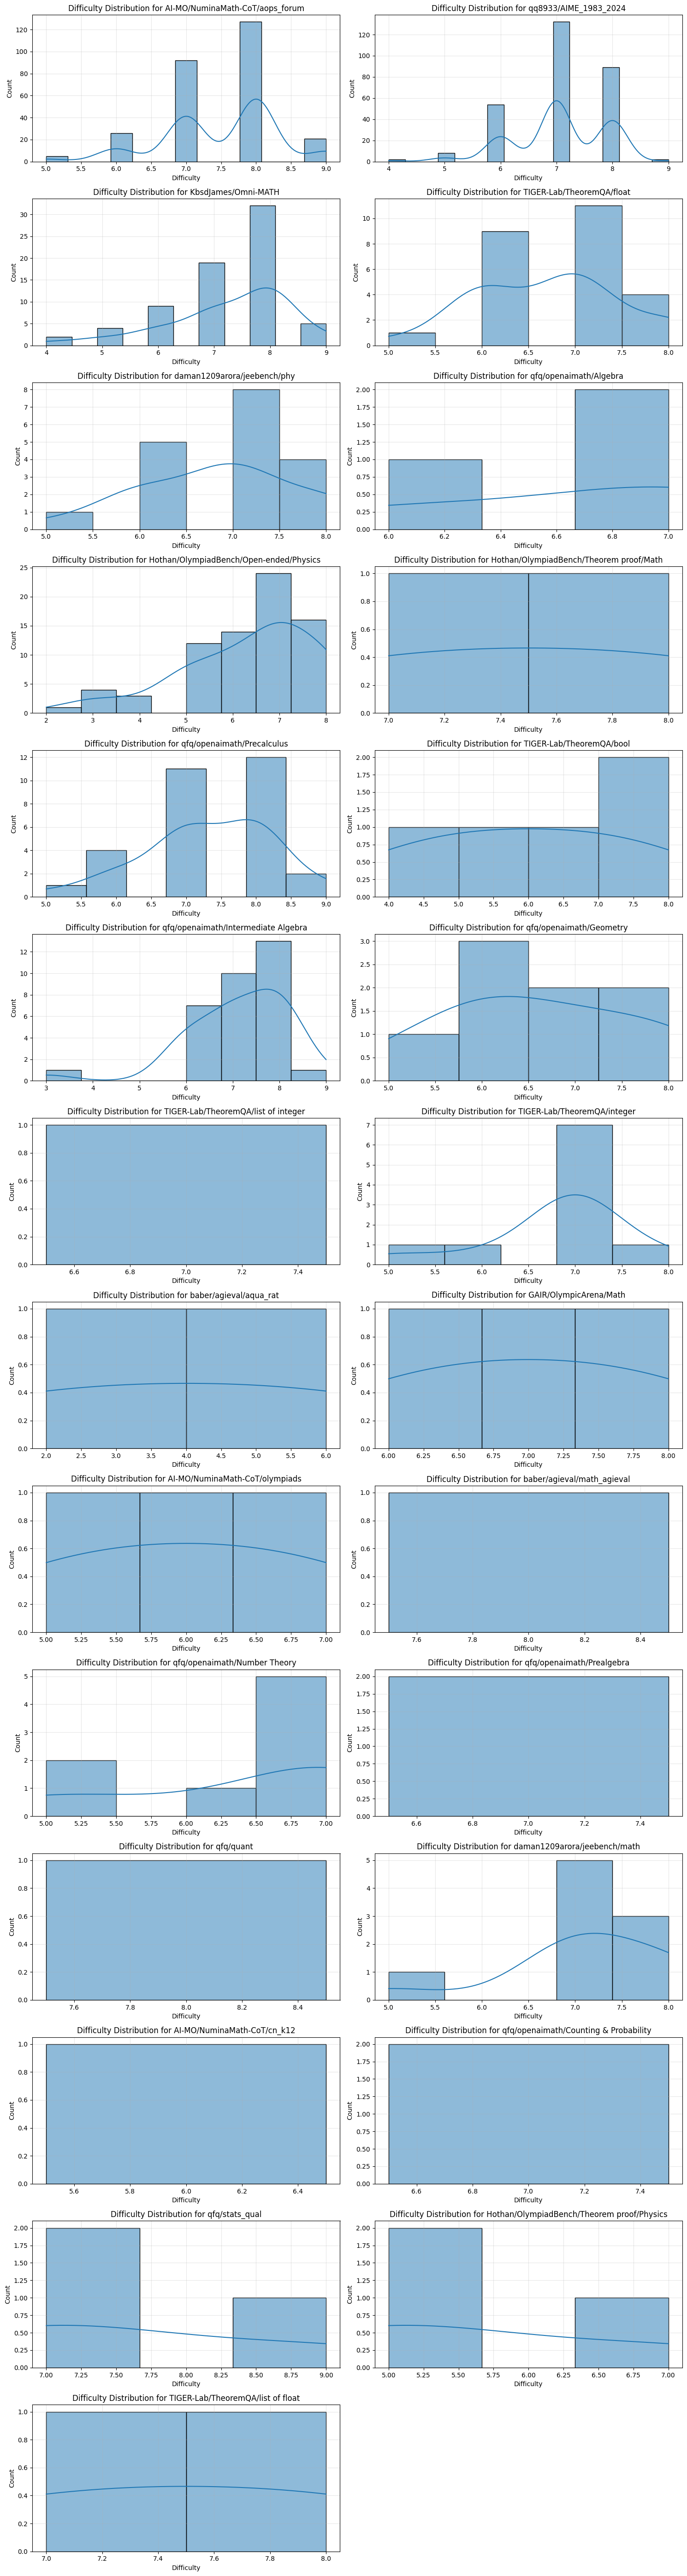

In [9]:
source_types = df['source_type'].unique()
n_cols = 2
n_rows = (len(source_types) + 1) // 2  # 소스 타입 수에 따라 행 수 계산

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, source_type in enumerate(source_types):
    source_data = df[df['source_type'] == source_type]
    # 이 서브플롯에 데이터가 있는지 확인
    if not source_data.empty:
        sns.histplot(data=source_data, x='difficulty', kde=True, ax=axes[i])
        axes[i].set_title(f'Difficulty Distribution for {source_type}')
        axes[i].set_xlabel('Difficulty')
        axes[i].set_ylabel('Count')
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].set_title(f'No data for {source_type}')
        axes[i].set_xlabel('Difficulty')
        axes[i].set_ylabel('Count')

# 남은 서브플롯 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('difficulty_by_source_subplots.png')
plt.show()

In [7]:
# 6. 통계적 요약 정보 출력
print("전체 데이터셋 난이도 통계:")
print(df['difficulty'].describe())

print("\n소스 타입별 난이도 통계:")
print(df.groupby('source_type')['difficulty'].describe())

전체 데이터셋 난이도 통계:
count    877.000000
mean       7.111745
std        1.030942
min        2.000000
25%        7.000000
50%        7.000000
75%        8.000000
max        9.000000
Name: difficulty, dtype: float64

소스 타입별 난이도 통계:
                                            count      mean       std  min  \
source_type                                                                  
AI-MO/NuminaMath-CoT/aops_forum             271.0  7.490775  0.842674  5.0   
AI-MO/NuminaMath-CoT/cn_k12                   1.0  6.000000       NaN  6.0   
AI-MO/NuminaMath-CoT/olympiads                3.0  6.000000  1.000000  5.0   
GAIR/OlympicArena/Math                        3.0  7.000000  1.000000  6.0   
Hothan/OlympiadBench/Open-ended/Physics      74.0  6.297297  1.468666  2.0   
Hothan/OlympiadBench/Theorem proof/Math       2.0  7.500000  0.707107  7.0   
Hothan/OlympiadBench/Theorem proof/Physics    3.0  5.666667  1.154701  5.0   
KbsdJames/Omni-MATH                          71.0  7.267606  1.133361  4.

In [31]:
ds = load_from_disk('/mnt/cephfs/sumin/sentence_kd/notebook/processed_dataset')

In [32]:
ds['train']['text'][0]

"<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant. Rate the difficulty of this problem on a scale of 1-10 and include it at the beginning of your response. Example: Difficulty: 5/10<|im_end|>\n<|im_start|>user\nLet  $a,b,A,B$  be given reals. We consider the function defined by \\[ f(x) = 1 - a \\cdot \\cos(x) - b \\cdot \\sin(x) - A \\cdot \\cos(2x) - B \\cdot \\sin(2x). \\] Prove that if for any real number  $x$  we have  $f(x) \\geq 0$  then  $a^2 + b^2 \\leq 2$  and  $A^2 + B^2 \\leq 1.$ <|im_end|>\n<|im_start|>assistant\nDifficulty: 7/10\n<|im_start|>think\nLet $f(x) = 1 - a \\cos x - b \\sin x - A \\cos 2x - B \\sin 2x \\geq 0$ for all $x \\in \\mathbb{R}$.\nWe want to show that $a^2 + b^2 \\leq 2$ and $A^2 + B^2 \\leq 1$.\n\nConsider specific values of $x$.\nFor $x=0$, $f(0) = 1 - a - A \\geq 0$, so $a+A \\leq 1$.\nFor $x=\\pi$, $f(\\pi) = 1 - a \\cos \\pi - b \\sin \\pi - A \\cos 2\\pi - B \\sin 2\\pi = 1 - a(-1) - b(0) - A(1) - B(0) = 1+a